# **Projet Deep Learning**

GIRARDIN Florian, LASTEYRIE Bastien, SENET Alexandre

## **Contexte et objectifs**

Pour cette exercice, deux problématiques se posent à nous.
1. Réussir à restaurer des images endommagées par des pixels blancs qui représentent la perte d'information. Pour cela, nous avons à disposition trois jeux de données. Le premier possède des images en bon état, le second possède des images peu endommagées et le troisième possède des images très endommagées.

2. Réussir à déchiffrer des images qui ont été préalablement chiffrées. Pour cela nous avons à disposition deux jeux de données. Le premier possède des images dans leur état d'origine et le second des images chiffrées.



## **Méthodologie pour entrainer, améliorer et valider un modèle**

Dans notre cas, les données d'entrée sont composées d'images colorisées de 96 par 96 pixels, et nous cherchons à produire des images colorisées de 96 par 96 pixels. Nous sommes donc dans un contexte de régression et non pas de classification. 

Nous avons commencé par implémenter l'ensemble des fonctions nécessaires à l'entrainement et l'exploitation d'un modèle: Déziper nos données, en faire des jeux de données, entrainer les modèles sur ces jeux de données, évaluer les modèles. Nous détaillerons les choix faits pour chacune de ces méthodes dans la suite de ce document.

Ensuite, nous avons choisi de commencer avec un CNN qui semble être le modèle le plus adapté que nous connaissons pour ce type de problématique. Comme nous n'avons besoin que d'images en sortie, il nous a semblé intelligent de ne réaliser que la partie convolution du modèle.

Une fois un modèle prêt à être testé, nous l'entrainons sur les jeux de données dit "Tiny" sur 3 ou 4 epoch maximum. Nous avons estimé cela suffisant pour juger de la capacité du modèle à donner un résultat intéressant ou, à minima, de l'effet des modifications que nous venons potentiellement de faire.
Si, après plusieurs modifications des hyperparamètres et essais du modèle nous obtenons un résultat prometteur sur quelques epochs, nous l'entrainons sur le jeu de données complet et l'évaluons.

Nous avons essayé de réaliser cette étape sur de nombreuses epoch pour provoquer l'overfitting mais cela nous prend beaucoup trop de temps. Entrainer un modèle relativement simple sur 20 epochs nous demande environ 6h quand on utilise les datasets 1A et 1B. Nous l'avons donc fait une fois pour l'exemple mais par la suite, les modèles ne sont entrainés que sur 5 epochs.

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from google.colab import drive

torch.manual_seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')


Pour les deux méthodes qui suivent, il n'y a rien de particulier à expliquer. La première permet de déziper nos jeux de données sur Google Drive et la seconde, qui nous a été directement donnée, permet la création de jeux de données utilisables qui contiennent des images de 96 par 96 pixels, sur 3 canaux pour les couleurs.

In [ ]:
def unzipDataset() :

  from google.colab import files
  import zipfile
  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_1A.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_1B.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Tiny/train_tiny_2.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Tiny")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Test/test.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Test")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_1A.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_1B.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")

  with zipfile.ZipFile("/content/drive/MyDrive/dataset/Full/train_2.zip") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dataset/Full")

#Dataloader
class LoadImages(Dataset):
    def __init__(self, transformed_dataset_path : str, original_dataset_path : str) -> None:
        super(LoadImages, self).__init__()
        
        self.transformed_dataset_path = transformed_dataset_path
        self.original_dataset_path = original_dataset_path

        e1 = np.load(original_dataset_path)
        
        self.original_dataset = np.reshape(e1, (-1, 3, 96, 96))
        
        e2 = np.load(transformed_dataset_path)
        self.transformed_dataset = np.reshape(e2, (-1, 3, 96, 96))
        
        self.size = len(self.original_dataset)
            
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.transformed_dataset[idx], self.original_dataset[idx])

Ci-après, notre méthode d'entrainement du modèle. Cette méthode contient l'entrainement mais également la validation pour chaque epoch. Ici, nous avons fait plusieurs choix que nous garderons pour toute la durée de ce projet mais qu'il serait en réalité intéressant de questionner pour optimiser les résultats.

En ce qui concerne l'optimizer, nous n'avons pas cherché davantage et sommes restés sur Adam.

En ce qui concerne la fonction de loss, nous nous sommes renseignés sur les fonctions disponibles. Nous avons retenu la L1Loss plutôt que la MSELoss car elle semble permettre d'éviter des problèmes lié au gradient.

Il nous a semblé intéressant de mettre en place une méthode qui permet d'ajuster le learning rate au fur et à mesure du déroulement des epochs dans le but d'améliorer la précision, quitte à perdre en rapidité. Comme nous savons que nous n'avons pas des ressources matérielles assez rapides pour réaliser de nombreuses epochs sur les jeux de données complets, nous savons que nous ne réaliserons que 10 ou 15 epochs lors des entrainements. Nous avons alors opté pour une division par 2 du learning rate toutes les 3 epochs en espérant que cela ne nous empêche pas de trouver de meilleures pentes si nous avions gardé le learning rate tel quel.

Avant d'utiliser la méthode, nous découpons le jeu de données d'entraînement en deux parties: 80% pour la partie qui permet l'entraînement du modèle et 20% pour la partie qui permet la validation.

La partie entrainement est classique et permet donc de s'entrainer sur la première partie du jeu de données.

La partie validation permet de vérifier l'évolution de la valeur de la loss pour maitriser l'overfitting. Dans notre cas, si la loss augmente trois fois de suite par rapport à sa valeur précédente, nous considérons être en phase d'overfitting et arrêtons le processus d'entrainement à cette epoch.

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR divided by 2 every 3 epochs"""
    lr = optimizer.param_groups[0]["lr"]
    if epoch % 3 == 1:
        if epoch > 1:
            lr = optimizer.param_groups[0]["lr"] / 2

    return lr

In [ ]:
def train_optim(model, device, valloader, trainloader, epochs, log_frequency, learning_rate=1e-4):
    model.to(device)  # we make sure the model is on the proper device

    loss_fn = torch.nn.L1Loss()
    loss_fn.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    previous_loss = 99.0
    loss_sup_in_a_row = 0
    for epoch in range(epochs):
        lr = adjust_learning_rate(optimizer, epoch)  # adjust the learning rate. Decreasing.
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        model.train()  # we specify that we are training the model

        start = time.time()  # start timer

        # At each epoch, the training set will be processed as a set of batches
        for batch_id, batch in enumerate(trainloader):

            images, labels = Variable(batch[0] / 255), Variable(batch[1] / 255, requires_grad=False)

            # we put the data on the same device
            images, labels = images.to(device), labels.to(device)

            y_pred = model(images)

            loss = loss_fn(y_pred, labels)

            if batch_id % log_frequency == 0:
                print(
                    "epoch: {:03d}, batch: {:03d}, loss: {:.12f}, time: {:.3f}".format(epoch + 1, batch_id + 1,
                                                                                      loss.item(),
                                                                                      time.time() - start))

            optimizer.zero_grad()  # clear the gradient before backward
            loss.backward()  # update the gradient

            optimizer.step()  # update the model parameters using the gradient

        # validation
        for batch_id, batch in enumerate(valloader):
            model.eval()
            images, labels = Variable(batch[0] / 255), Variable(batch[1] / 255, requires_grad=False)
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            print("loss: {:.12f}".format(loss.item()))
            if previous_loss < loss:
                loss_sup_in_a_row += 1
                if loss_sup_in_a_row >= 3:
                  torch.save(model.state_dict(), '/content/drive/MyDrive/modeltrained/model_overfit_limit.pt')
                  return
            else:
                loss_sup_in_a_row = 0

Ci-après, notre méthode d'évaluation. Cette méthode utilisera uniquement les jeux de données de "test". C'est à dire des jeux de données qui n'ont encore jamais servi et surtout pas à l'entrainement du modèle.

Ici, on réalise la somme des absolus de la différence entre les images attendues et les images prédites. Pour chaque batch, cette valeur est divisée par la taille du batch pour obtenir une valeur moyenne par image. Cette valeur moyenne est sommée pour obtenir un total. Il ne reste qu'à divisier ce total par le nombre de batch réalisé pour obtenir le score moyen d'une image sur le dataset.

Nous effectuons également un affichage de quelques résultats pour se donner une représentation visuelle.

Nous pensons qu'il serait intéressant d'établir en complément un tableau basé sur divers critères pondérés par importance pour mieux départager les modèles en définitive. On incluerait par exemple le temps d'entrainement/le nombre de paramètres produits lors de son entrainement, les ressources consommées, l'appréciation visuelle humaine, etc..

Malheureusement, il nous semble un peu ambitieux de définir la pondération par nous même et nous manquons de temps. C'est donc bel et bien le score qui nous permettra d'estimer l'efficacité d'un modèle et donc de juger de l'amélioration.

In [ ]:
def eval(model, device, dataset_evaluated, batch_size, nb_image_to_print):
    if nb_image_to_print > batch_size:
        nb_image_to_print = batch_size
    model.to(device)
    model.eval()
    loss_fn = torch.nn.L1Loss()
    loss_fn.to(device)
    with torch.no_grad():
        general_avg = 0.0
        i = 0
        for batch_id, batch in enumerate(dataset_evaluated):
            i += 1
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            out_pred = model(images)
            loss = loss_fn(out_pred, labels)
            val = torch.abs(labels - out_pred).sum().cpu()
            if i < nb_image_to_print:
                fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 4))
                idx = 1
                ax = fig.add_subplot(1, 3, idx, xticks=[], yticks=[])
                plt.imshow(labels[i].cpu().permute(1, 2, 0))
                ax.set_title("Labels")
                idx += 1
                ax = fig.add_subplot(1, 3, idx, xticks=[], yticks=[])
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                ax.set_title("Images")
                idx += 1
                ax = fig.add_subplot(1, 3, idx, xticks=[], yticks=[])
                plt.imshow(out_pred[i].cpu().permute(1, 2, 0))
                ax.set_title("Predicted")
                idx += 1
                plt.show()
            print("Metric for a batch: " + str(val.item()) + "loss:{:.12f}", loss.item())
            print("Moyenne du batch par image: " + str(val.item() / images.size()[0]))
            general_avg = general_avg + (val.item() / images.size()[0])
    print("Moyenne general d'une image sur le dataset évalué: " + str(general_avg / i))

# **Modèle 1**

In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu1 = nn.ReLU()
        self.avgpool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu2 = nn.ReLU()
        self.avgpool2 = nn.AvgPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=1024, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        '''
        out = self.avgpool1(self.relu1(self.conv1(x)))
        print(out.shape)
        out = self.avgpool2(self.relu2(self.conv2(out)))
        print(out.shape)
        '''
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        out = torch.add(out, x)
        return out


Pour ce premier modèle, nous avions commencé avec un modèle proche d'un CNN.

Que nous changions le nombre de neurones, le nombre de layers, la taille d'un kernel ou même de fonction d'activation, nous ne parvenions pas à obtenir de combinaison avec un résultat ne serait-ce que proche de l'attendu. Finalement, nous nous sommes résolus à faire des recherches sur Internet dans l'idée de trouver des pistes d'évolution. Il s'avère que les méthodes de pooling portent préjudice au modèle. Nous avons donc décidé de les enlever et de créer un modèle très simple en nombre de layers mais avec une quantité importante de neurones. De plus, l'ajout de la méthode torch.add qui réaliser la somme des valeurs qui composent deux tensor nous a permit d'obtenir des résultats encore meilleur.

**Résultat sur test_1A avec train_1A pour entrainer ce premier modèle. Il s'agira de l'unique fois où nous avons pu réaliser l'entrainement sur 20 epochs :**

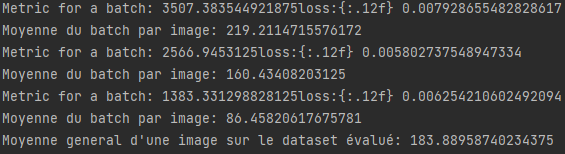

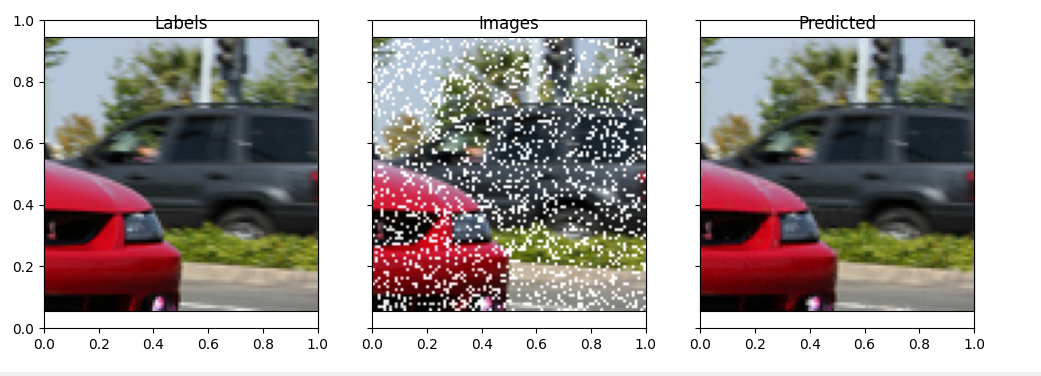

**Résultat sur test_1B avec train_1B pour entrainer ce premier modèle**

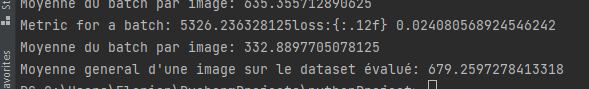

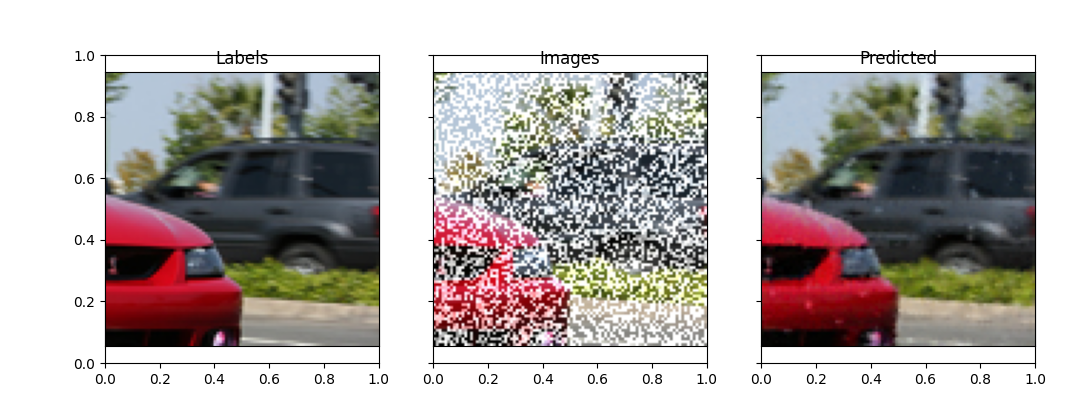

Finalement, nous avons tenté d'entrainer ce modèle sur la partie chiffrement/déchiffrement mais il était évident qu'il fallait repenser totalement le modèle. En effet, les résultats étaient suffisament mauvais pour affirmer que quelques ajustements de paramètres n'auraient pas suffit.

# **Modèle 2**



Suite au modèle précédent qui était déjà très intéressant, nous avons pensé qu'un second modèle plus riche en couches serait plus efficace. L'idée était de garder un nombre de neurones par couche relativement faible pour voir si l'augmentation de couche pouvait compenser la quantité de neurones. Nous avons également remplacé la méthode d'activation Relu par PRelu mais la différence n'est pas vraiment notable que l'on utilise l'une ou l'autre.


In [ ]:
class CustomModel2(nn.Module):
    def __init__(self):
        super(CustomModel2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False)
        self.relu2 = nn.PReLU()
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False)
        self.relu3 = nn.PReLU()
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu4 = nn.PReLU()
        self.subpixel2 = nn.PixelShuffle(2)
        self.conv_output2 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)
        self.subpixel1 = nn.PixelShuffle(16)
        self.conv_output1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        item = x
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.relu3(self.conv3(out))
        res = out
        out = self.relu4(self.conv4(out))
        print("before add")
        print(out)
        out = torch.add(out, res)
        print("après add")
        print(out)
        out = self.subpixel2(out)
        out = self.conv_output2(out)
        out = torch.add(out, item)

        return out

**Résultat sur test_1A avec train_1A pour entrainer ce deuxième modèle :**

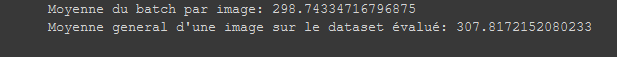

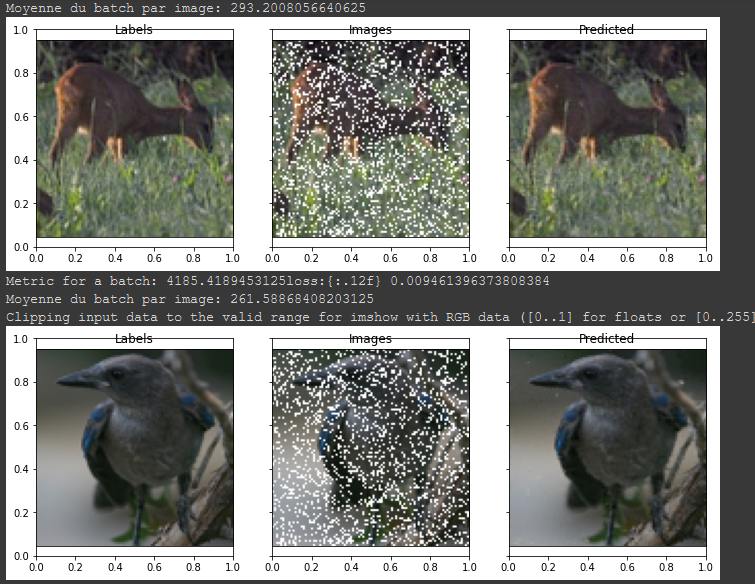

**Résultat sur test_1B avec train_1B pour entrainer ce deuxième modèle :**

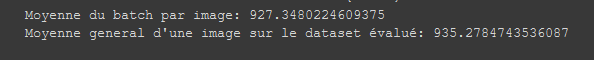

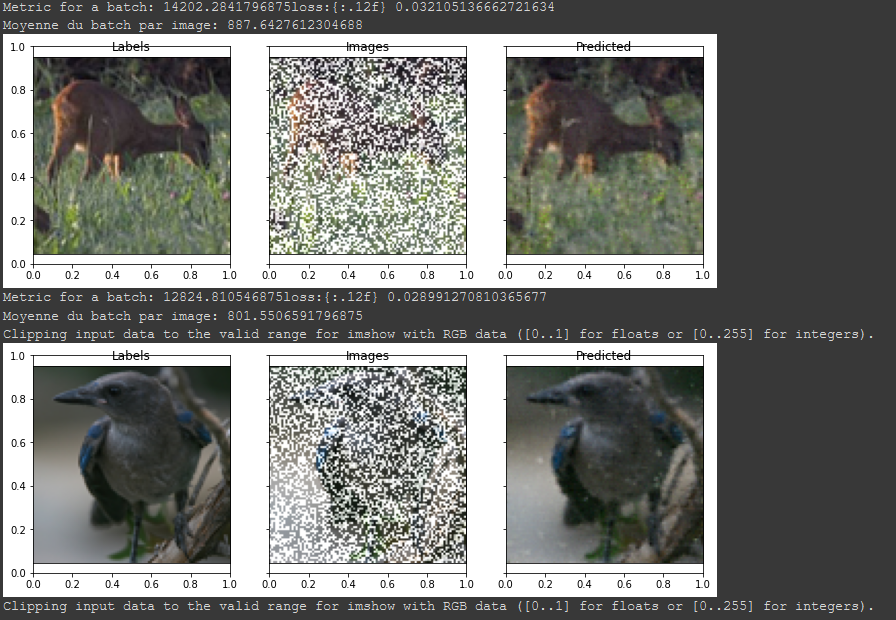

# **Conclusion sur la restauration d'image**

Finalement, un modèle peu complexe en couche mais avec une grande quantité de paramètres s'est avéré plus efficace. C'est en tout cas ce que laisse penser nos deux exemples mais il ne faut pas oublier que nous nous sommes arrêté très vite sur le nombre d'epoch plutôt que d'atteindre l'overfitting. Il est possible qu'avec plus d'entrainement la tendance s'inverse ou qu'en tout cas les modèles finissent par se valoir.

On notera également que nous n'avons pas pu explorer d'autres méthodes que la convolution. 

# **Déchiffrement - Modèle 3** 

## **Compréhension de l'énoncé**

En première approche, cette problématique semblait juste être une version plus complexe du premier problème. Cependant il nous est rapidement apparu après avoir tenté d'utiliser nos modèles utilisant la convolution sur ce nouveau dataset que nous ne parviendrions pas à un résultat correct.

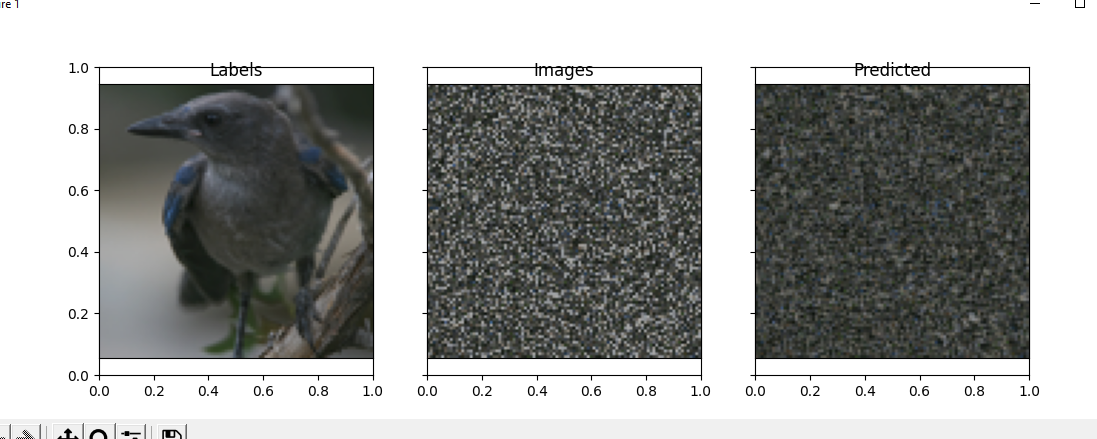

Nous avons alors cherché à mieux comprendre la tâche qui nous était confiée. Et c'est à ce moment que nous avons compris que les images abîmées n'avaient pas été abîmées de la même manière que pour le premier dataset mais que les pixels de l'image étaient simplement mélangés. Nous avons immédiatement supposé que le mélange était identique pour toutes les images et nous avons commencé à concevoir un modèle basé sur cette supposition pour confirmer notre théorie. Une fois nos premiers tests effectués, nous avions une vision beaucoup plus claire de la tâche.



### **Première stratégie**

A la vue des performances obtenues par notre modèle de convolution, il était évident que ca n'était pas la bonne approche, en effet, réaliser un tri des pixels ne necessite aucune conservation des données spatiales relatives entre les pixels de l'image chiffrée d'origine. 

Notre premier modèle était un modèle très simple, comportant une unique couche comportant autant de neurone que de pixels dans l'image.


In [ ]:
class DecryptionModelv1(nn.Module):
    def __init__(self):
        super(DecryptionModel, self).__init__()
        self.flatten = nn.Flatten()
        self.relu1 = nn.ReLU()
        self.linear = nn.Linear(27648, 27648)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.relu1(x)
       x = torch.reshape(red, [red.shape[0],1, 96, 96])
        return x


Ce premier modèle fonctionnait uniquement sur cpu car sa consommation en mémoire vive dépassait les capacités de nos machines et même celles de google colab. Nous avons donc du repenser complètement notre méthodologie pour optimiser notre modèle.

Nous avons immédiatement pensé à nous débarasser des couleurs sur les images lors du chargement du dataset mais n'avons pas réussi à trouver la syntaxe permettant de transformer l'image en nuance de gris tout en conservant l'information sur les couleurs permettant de la repasser en couleur après le traitement.

###**Seconde stratégie : fusion des couches**

Notre seconde approche fu donc de fusionner les 3 layers de notre dataset en un unique afin d'avoir un traitement sur seulement un tier de la taille d'origine de  l'image. Cependant, notre méthodologie de fusion ne nous permettait pas d'obtenir des performances satisfaisante car l'information sur les couches était formalisée de tel manière qu'il était impossible que notre modèle comprenne.

In [ ]:
class DecryptionModelv2(nn.Module):
    def __init__(self, mille, centmille):
        super(DecryptionModel, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.relu1 = nn.ReLU()
        self.linear = nn.Linear(9216, 9216)
        self.linear = nn.Linear(9216, 9216)
        self.linear = nn.Linear(9216, 9216)
        self.mille = mille
        self.centmille = centmille

    def forward(self, x):
        x = x.permute(1, 0, 2, 3)
        blue = x[0]
        green = x[1]
        red = x[2]
        blue = torch.add(blue, self.mille)
        x = torch.add(green, blue)
        red = torch.add(red, self.centmille)
        x = torch.add(x, red)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.relu1(x)
        x = torch.reshape(x, [x.shape[0], 96, 96])
        violet = torch.sub(x, red)
        newblue = torch.sub(violet, green)
        newgreen = torch.sub(violet, blue)
        newblue = torch.sub(newblue, self.mille)
        newred = torch.sub(x, violet)
        newred = torch.sub(newred, self.centmille)
        x = torch.stack((newblue, newgreen, newred))
        x = x.permute(1, 0, 2, 3)
        return x

Les résultats de ce modèles étaient particulièrement mauvais et nous avons donc décidé de l'abandonner.

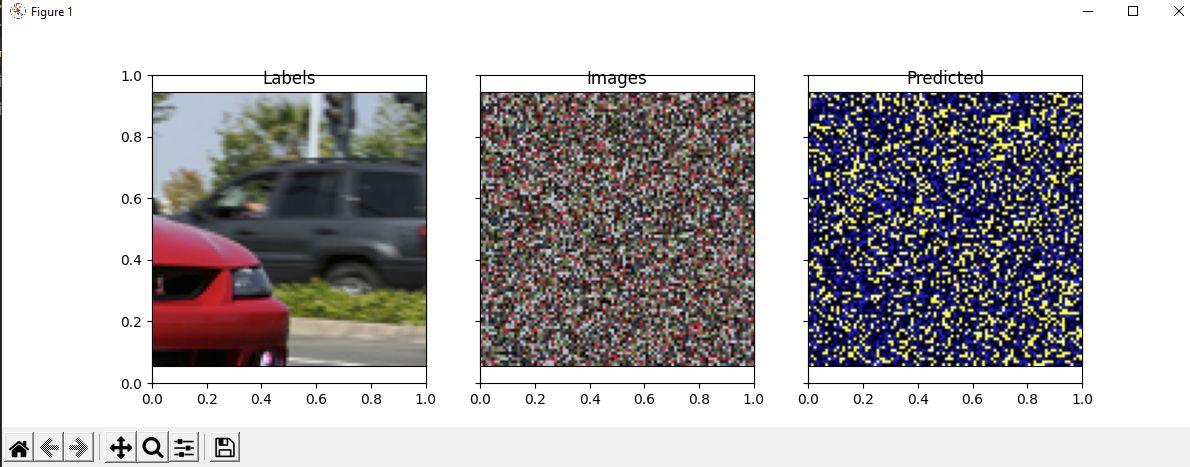

###**Tentative finale**

Notre ultime stratégie fu donc de diviser notre image en couche de couleurs et d'entrainer une unique couche de taille raisonnable (96*96 neuronnes) sur chacune des couches.

In [ ]:
class DecryptionModel(nn.Module):
    def __init__(self):
        super(DecryptionModel, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.relu1 = nn.PReLU()
        self.linear = nn.Linear(9216, 9216)

    def forward(self, x):
        x = x.permute(1, 0, 2, 3)
        blue = x[0]
        green = x[1]
        red = x[2]
        mix = torch.add(blue,green)
        mix = torch.add(mix,red)
        mix = self.flatten(mix)
        mix = self.linear(mix)
        mix = self.relu1(mix)
        blue = self.flatten(blue)
        blue = self.linear(blue)
        blue = self.relu1(blue)
        green = self.flatten(green)
        green = self.linear(green)
        green = self.relu1(green)
        red = self.flatten(red)
        red = self.linear(red)
        red = self.relu1(red)
        blue = torch.reshape(blue, [blue.shape[0], 96, 96])
        green = torch.reshape(green, [green.shape[0], 96, 96])
        red = torch.reshape(red, [red.shape[0], 96, 96])
        x = torch.stack((blue, green, red))
        x = x.permute(1, 0, 2, 3)
        return x

Immédiatement les résultats de cette méthode se sont avérés correct à ceci près que nous avions des soucis de tâches noires sur les images que nous ne comprenions pas. Après quelques recherches, il s'est avéré que cela provenait de notre fonction d'activation (relu).

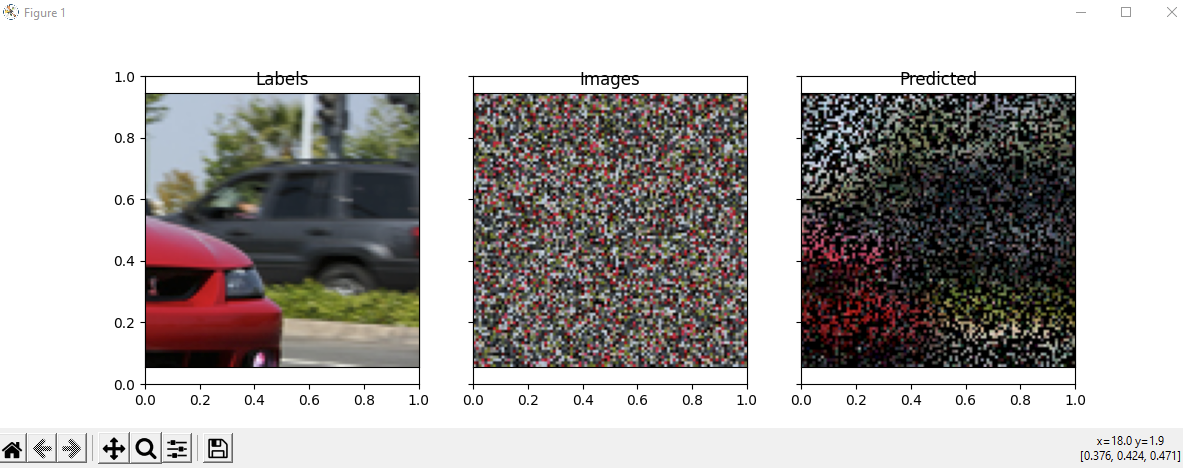

Nous avons donc utilisé la fonction PRelu et nous avons obtenu des performances correctes. Nous avons donc défini ce modèle comme étant final et avons entrainé ce dernier sur 90 epoch sur le dataset complet afin d'obtenir un score. Nous ne sommes pas parvenus à atteindre l'overfitting sur ce dataset.

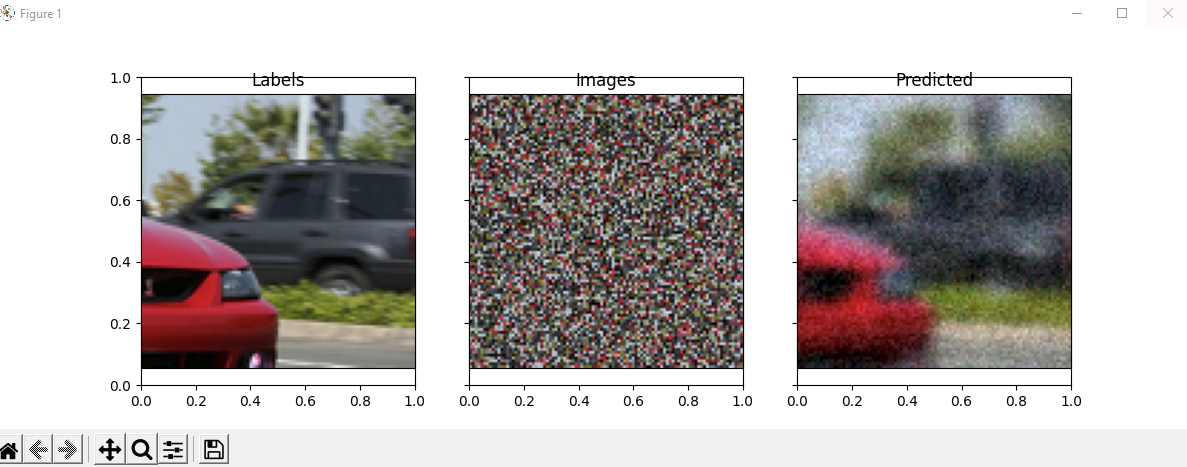

Ci-dessus un exemple de résultat après 20 epoch d'entrainement.

Ci-dessous le même résultat mais après 70 epoch d'entrainement.

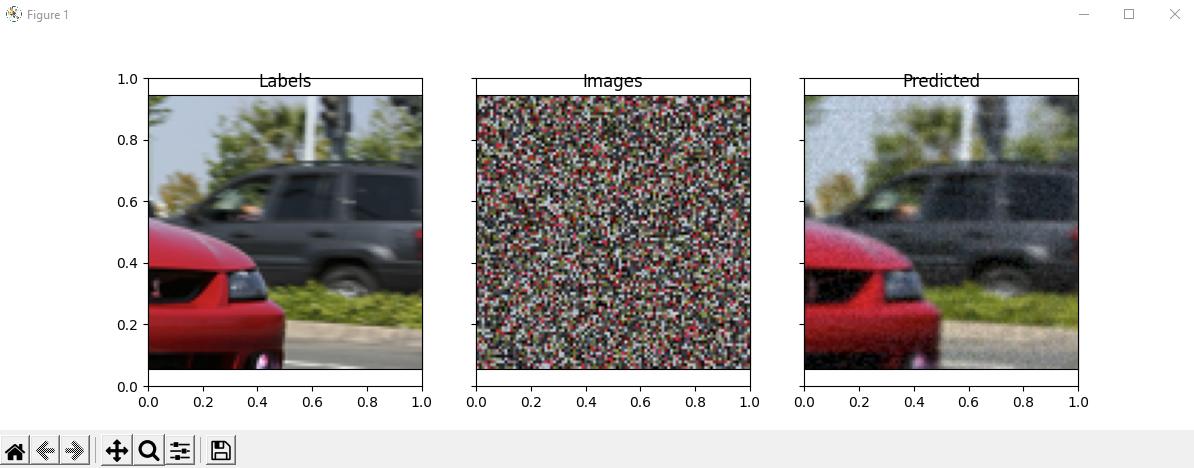

In [ ]:
#Uncomment the function below to unzip datasets
#unzipDataset()

def eval_dataset(model, batch_size):
  source_original = "/content/drive/MyDrive/dataset/Test/test_original.npy"
  source_damaged = "/content/drive/MyDrive/dataset/Test/test_1A.npy"
  dataset = LoadImages(source_damaged, source_original)
  testloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
  eval(model, device, testloader, batch_size, 10)

def train_dataset(model, batch_size, do_save, do_load):
  if do_load:
    model.load_state_dict(torch.load("./modeltrained/1A_Tiny_3epoch_model.pt"))
  source_original = "/content/drive/MyDrive/dataset/Full/train_original.npy"
  source_damaged = "/content/drive/MyDrive/dataset/Full/train_1A.npy"
  dataset = LoadImages(source_damaged, source_original)
  trainsize = int(len(dataset) * 80 / 100)
  valsize = int(len(dataset) - trainsize)
  train_set, val_set = torch.utils.data.random_split(dataset, lengths=[trainsize, valsize])
  valloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
  trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
  nb_epoch = 5
  log_frequency = 10
  learning_rate = 1e-4
  train_optim(model, device, valloader, trainloader, nb_epoch, log_frequency, learning_rate)
  if do_save:
    torch.save(model.state_dict(), '/content/drive/MyDrive/modeltrained/modelA_1A.pt')



batch_size = 16
model = CustomModel2()
do_save = True
do_load = False
train_dataset(model, batch_size, do_save, do_load)
eval_dataset(model, batch_size)



# **Scores finaux :**

Voici nos scores finaux sur chacun des jeux de données :

Pour les cas où le nombre d'epoch n'est pas précisé, nous en avons réalisé 5.


|          | Test 1A   |     Test 1B  |  Test 2 |
|----------|-----------|--------------|---------|
| Modèle 1 |  183,88 (20 epoch) |   679,25     |  NA   |
| Modèle 2 |   307,81   |   935,27 |    NA |
| Modèle 3 | NA |   NA | 969,16 (90 epoch) |